In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
np.random.seed(42)

# Markov Chains

### The principle idea of Markov chains is that the future is independent of the past given the present. In other words, the probability of transitioning to any particular state depends only on the current state and time step, and not on the states that preceded it. This is called the Markov property.

### So, clearly we will use the "state vector" concept to set this up.

In [2]:
# Allowed states
state_space = ("sunny", "cloudy", "rainy")

In [3]:
# Transition matrix
transition_matrix = np.array([
    [0.6, 0.3, 0.1],
    [0.3, 0.4, 0.3],
    [0.2, 0.3, 0.5]
])

# note that the sum of each row in the transition matrix must be 1

In [4]:
# Run the Markov chain for a while

n_steps = 20000
states = [0]
for i in range(n_steps):
    states.append(np.random.choice((0, 1, 2), p=transition_matrix[states[-1]]))
states = np.array(states)

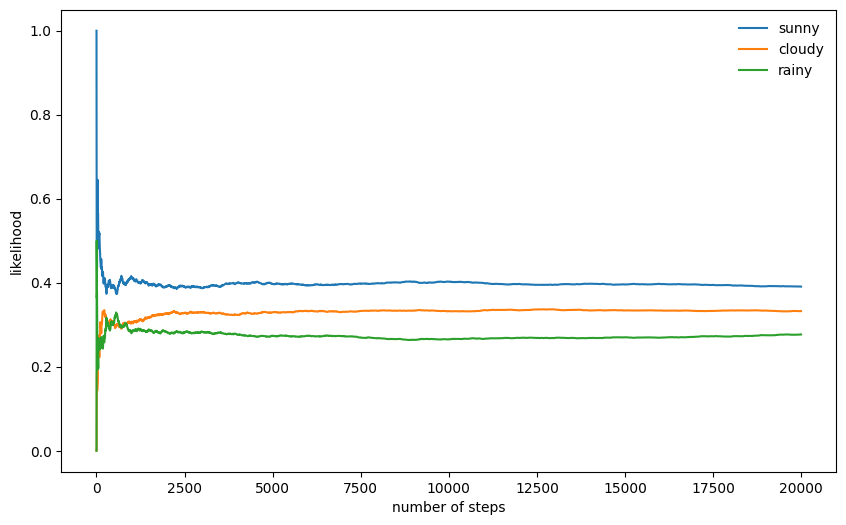

In [7]:
# Plot the states

#def despine(ax, spines=('top', 'left', 'right')):
#    for spine in spines:
#        ax.spines[spine].set_visible(False)

fig, ax = plt.subplots()
width = 1000
offsets = range(1, n_steps, 5)
for i, label in enumerate(state_space):
    ax.plot(offsets, [np.sum(states[:offset] == i) / offset
            for offset in offsets], label=label)
ax.set_xlabel("number of steps")
ax.set_ylabel("likelihood")
ax.legend(frameon=False)
#despine(ax, ('top', 'right'))
plt.show()

# Observations

### 1. There is a "burn in" period where the likelihood of each state is changing. This is because we started in a particular state (sunny) and the Markov chain is adjusting to the initial state.  This is a common problem with Markov chains, and there are ways to deal with it.  For example, we could start in a random state, or we could run the chain for a while and then start recording the states.  In this case, we will just ignore the burn in period.

### 2. The system does reach a state of equilibrium.  This is because the transition matrix is stochastic (the sum of each row is 1).  In this case, the equilibrium state is the same as the stationary distribution.  We can see that the likelihood of each state is the same as the values in the stationary distribution.

### 3. Notice that when we make the plot, we are dividing by the number of steps.  This is because we are interested in the likelihood of each state, not the number of times we are in each state.  For example, if we are in the sunny state 100 times, but we have taken 1000 steps, then the likelihood of being in the sunny state is 0.1.

### 4. Also, in the plots, we are only plotting every 5th step.  This is known as lag.  We do this because the states are correlated.  In other words, the state at step 100 is likely to be the same as the state at step 99.  This is a common problem with Markov chains, and there are ways to deal with it.  For example, we could use a different transition matrix, or we could use a different lag.  In this case, we will just ignore the lag.

# Steady State

### The steady state is the state of the system that does not change.  In other words, it is the state of the system that the system will eventually reach and stay in.  In this case, the steady state is the same as the stationary distribution.  We can calculate the steady state by raising the transition matrix to a large power.  In this case, we will raise the transition matrix to the 100th power.

### Note that the steady state is the same as the stationary distribution.

In [8]:
import numpy.linalg as linalg

steady_state = linalg.matrix_power(transition_matrix, 100)

print(steady_state)

[[0.38888889 0.33333333 0.27777778]
 [0.38888889 0.33333333 0.27777778]
 [0.38888889 0.33333333 0.27777778]]


# Metroplis-Hastings

### The Metropolis-Hastings algorithm is a Markov chain Monte Carlo (MCMC) method for obtaining a sequence of random samples from a probability distribution for which direct sampling is difficult. This sequence can be used to approximate the distribution (i.e., to generate a histogram of the distribution); to compute an integral (such as an expected value); or to compute other measures such as autocorrelation.

### We want to sample from an arbitary probability distribution, $\pi$.  It could be discrete or continuous.  We are going to focus here on the continuous case (where the Transition Matrix is actually a Transition Kernel.  We will use the Metropolis-Hastings algorithm to sample from $\pi$.

### Now, if we knew what $\pi$ was, we'd be done, because we would just immediately sample from $\pi$.  But we don't ... that is the whole point of what we are trying to do here ... we are trying to determine what $\pi$ is by sampling from it.  So, we need to start with some initial distribution, $q$. We will call this the proposal distribution.  Then, we will design an acceptance/rejection step to determine whether or not to accept the proposed sample.  If we accept the proposed sample, then we will add it to our sample set.  If we reject the proposed sample, then we will not add it to our sample set.  We will repeat this process until we have enough samples.

### We thus have that:

### $$T(x_{i+1}|x_i) = q(x_{i+1}|x_i) \times p_{acc}(x_{i+1}|x_i)$$

### where $T(x_{i+1}|x_i)$ is the transition kernel, $q(x_{i+1}|x_i)$ is the proposal distribution, and $p_{acc}(x_{i+1}|x_i)$ is the acceptance probability.

### A sufficient condition for the Markov chain to have $\pi$ as its stationary distribution is that the chain be irreducible and aperiodic.  This can be written as:

### $$\pi(x) \times T(x_{i+1}|x_i) = \pi(x_{i+1}) \times T(x_i|x_{i+1})$$

### The Metropolis-Hastings algorithm says that the acceptance probability is:

### $$p_{acc}(x_{i+1}|x_i) = min\left(1, \frac{\pi(x_{i+1}) \times q(x_i|x_{i+1})}{\pi(x_i) \times q(x_{i+1}|x_i)}\right)$$

In [9]:
def log_prob(x):
    return -np.sum(x**2) / 2.0

# Note that this corresponds to a multivariate normal distribution with mean 0 and sigma of 1 (if we were to exponentiate it)

In [10]:
# Define the proposal distribution

def proposal(x,stepsize):
    return np.random.uniform(low=x-0.5*stepsize, high=x+0.5*stepsize, size=x.shape)

In [11]:
# Define the acceptance probability

def p_acc_MH(x, x_new, log_prob):
    p_acc = np.exp(log_prob(x_new) - log_prob(x))
    return np.minimum(1, p_acc)

In [12]:
# Define the Metropolis-Hastings sampling step

def sample_MH(x_old, log_prob, stepsize):
    x_new = proposal(x_old, stepsize)
    accept = np.random.rand() < p_acc_MH(x_old, x_new, log_prob)
    if accept:
        return accept, x_new
    else:
        return accept, x_old

In [13]:
def build_MH_chain(init, stepsize, n_total, log_prob):

    n_accepted = 0
    chain = [init]

    for _ in range(n_total):
        accept, state = sample_MH(chain[-1], log_prob, stepsize)
        chain.append(state)
        n_accepted += accept

    acceptance_rate = n_accepted / float(n_total)

    return chain, acceptance_rate

In [14]:
chain, acceptance_rate = build_MH_chain(np.array([2.0]), 3.0, 10000, log_prob)
chain = [state for state, in chain]
print("Acceptance rate: {:.3f}".format(acceptance_rate))
last_states = ", ".join("{:.5f}".format(state)
                        for state in chain[-10:])
print("Last ten states of chain: " + last_states)

Acceptance rate: 0.720
Last ten states of chain: 1.05847, 1.59966, 0.14389, -1.13281, 0.24131, -0.77448, -0.59703, 0.67707, 1.47065, 1.27361


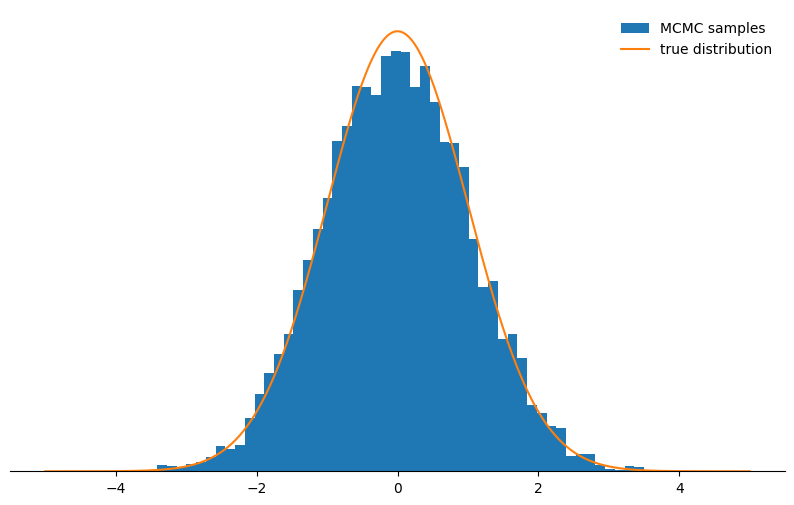

In [15]:
def plot_samples(chain, log_prob, ax, orientation='vertical', normalize=True,
                 xlims=(-5, 5), legend=True):
    from scipy.integrate import quad

    ax.hist(chain, bins=50, density=True, label="MCMC samples",
           orientation=orientation)
    # we numerically calculate the normalization constant of our PDF
    if normalize:
        Z, _ = quad(lambda x: np.exp(log_prob(x)), -np.inf, np.inf)
    else:
        Z = 1.0
    xses = np.linspace(xlims[0], xlims[1], 1000)
    yses = [np.exp(log_prob(x)) / Z for x in xses]
    if orientation == 'horizontal':
        (yses, xses) = (xses, yses)
    ax.plot(xses, yses, label="true distribution")
    if legend:
        ax.legend(frameon=False)

fig, ax = plt.subplots()
plot_samples(chain[500:], log_prob, ax)
despine(ax)
ax.set_yticks(())
plt.show()

Acceptance rate: 0.104


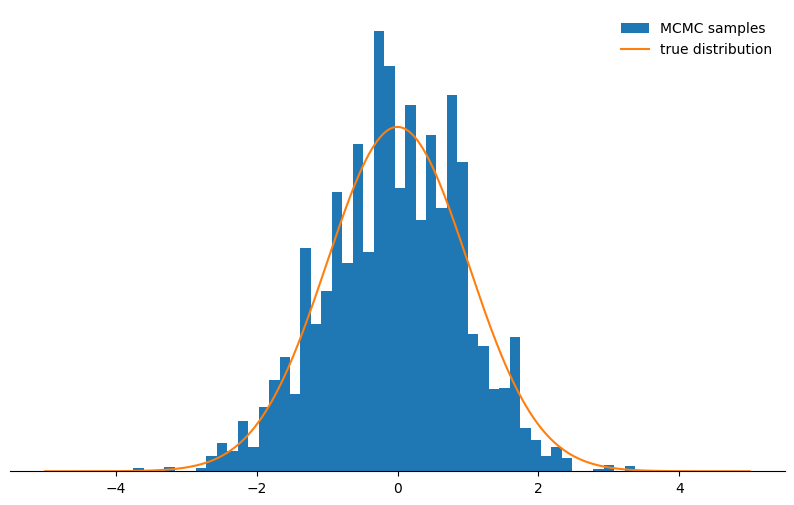

In [16]:
def sample_and_display(init_state, stepsize, n_total, n_burnin, log_prob):
    chain, acceptance_rate = build_MH_chain(init_state, stepsize, n_total, log_prob)
    print("Acceptance rate: {:.3f}".format(acceptance_rate))
    fig, ax = plt.subplots()
    plot_samples([state for state, in chain[n_burnin:]], log_prob, ax)
    despine(ax)
    ax.set_yticks(())
    plt.show()

sample_and_display(np.array([2.0]), 30, 10000, 500, log_prob)

Acceptance rate: 0.985


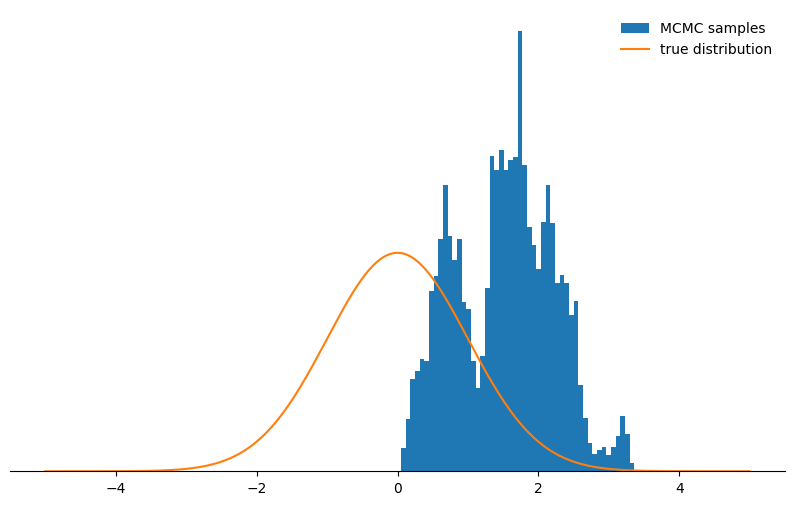

In [17]:
sample_and_display(np.array([2.0]), 0.1, 10000, 500, log_prob)


Acceptance rate: 0.990


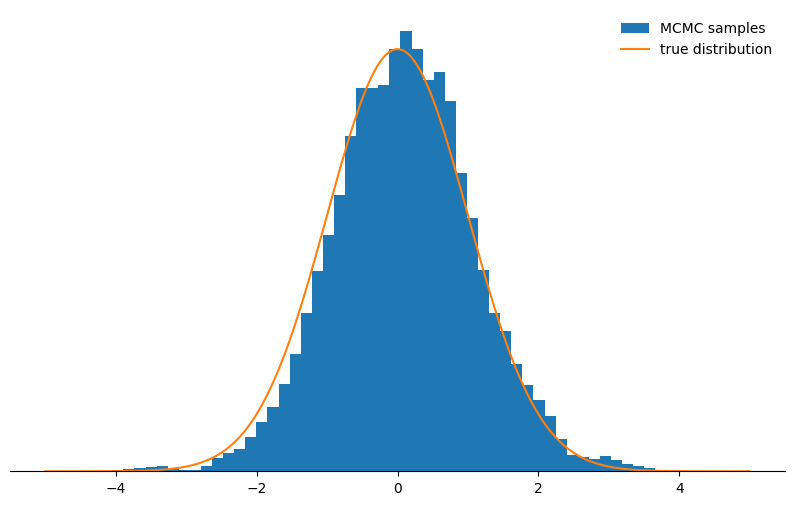

In [18]:
sample_and_display(np.array([2.0]), 0.1, 500000, 25000, log_prob)